In [48]:
# library Imports 

import pandas as pd
from pandas.io.stata import StataReader
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import DBSCAN
import string
import re
from contractions import fix
from nltk import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
import spacy
import numpy as np

# Loading the data

In [49]:
data_encoded = pd.read_stata('ukcv.dta', convert_categoricals=False)
data_encoded.head()

,psid,supportname,age,gender,genderbirth,ethnicity,bmi,smoke,preautoimmunity,preautoimmunitymeds,...,dxwhy_dismiss,dxwhy_help,dxwhy_guide,dxwhy_research,dxwhy_aware,dxwhy_oth,story_open,consented,supportgroup,trigvax
0,907633-907615-96019409,UKCV Covid Vaccine - Long Haul Autoimmune Sup...,2,2,1.0,3,2,1,0,0,...,0,1,1,1,1,0,,10.0,1.0,1.0
1,907633-907615-96026239,Uk cv group,8,1,1.0,3,3,3,0,2,...,0,0,0,0,0,0,,10.0,1.0,1.0
2,907633-907615-96025984,,3,2,1.0,4,3,3,0,0,...,1,1,1,1,1,1,A day after my first (and only) Pfizer vaccine...,10.0,3.0,1.0
3,907633-907615-96027621,Uk Cv family,4,2,1.0,3,2,3,0,0,...,1,1,1,0,1,0,It was quite tricky to fill in the time line o...,10.0,1.0,1.0
4,907633-907615-96027090,Ukcv family Facebook,7,2,1.0,3,4,2,0,0,...,0,1,1,1,1,0,Ive had mixed experiences with my GP practice...,10.0,1.0,1.0


Filtering for the textual data - focusing on text for this small demo

In [50]:
# The textual columns that I'm looking at:
textual_data = data_encoded.select_dtypes(include=['object'])
textual_data = textual_data.drop(['psid', 'supportname', 'batchno', 'story_open'], axis=1)
textual_data.head(2)

,opensxtrig_fatigue,opensxtrig_lhead,opensxtrig_vert,opensxtrig_cog,opensxtrig_tin,opensxtrig_naus,opensxtrig_weak,opensxtrig_ins,opensxtrig_breath,opensxtrig_exint,...,opensxtrig_food,opensxtrig_bb,opensxtrig_anx,opensxtrig_dep,opensxtrig_hal,opensxtrig_mood,sx_other_open,othertests,other_diag_open,tx_other_open
0,Periods Post-exertional malaise,Periods,Periods Sensory stimulation Video calls Pho...,Periods,Music Sensory stimulation,Periods Fatigue Hunger,Periods Fatigue,Relapses,Sitting upright Being active (e.g. being at w...,,...,,,,,,,Numb hands and feet,,,Omega 3 Folate
1,,,,,,,,,,,...,,,,,,,,,,


# Generating the medical_terms list

Loading the bio-medical model, this is used to identify medical terms in the text

In [51]:
punctuation = string.punctuation
stopwords_list = stopwords.words('english')
nlp = spacy.load("en_core_sci_lg")

Below is a small demo showing how the terms are found in the sentence in the code below.

In [52]:
# Process biomedical text
doc = nlp("This is a sample sentence containing medical terms like diabetes, hypertension, and cancer, PEM, Post-exertional malaise, light headed")

# Access biomedical entities
for ent in doc.ents:
    print(ent.text, ent.label_)

sample sentence ENTITY
medical ENTITY
diabetes ENTITY
hypertension ENTITY
cancer ENTITY
PEM ENTITY
Post-exertional malaise ENTITY
light headed ENTITY


The code below is doing the majority of the transformations, trying to combine similar words ect.
There are some notes scattered throughout the code below, however below is an overview of what it does:

1. Finds medical terms
2. Expands the contractions - i.e. can't -> cannot (easier to process later)
3. Removed punctuation
4. Lemmatizes - attempts to reduce words into their base-form - i.e. running -> run
5. Lower-cases everything and removes stop-words (words like "the", "and", "but" ect...)
6. Removes any extra spaces, making the words unreadable
7. Contains a transformations dictionary - this contains various codings for transformations that can be applied -> this needs to be added to
8. That transformation dictionary is applied on the data

In [79]:
#Function that I'm working on - still working on this
symptoms_list = []

def find_symptoms(data):
    
    # Step 1: Join
    data = " ".join(data)
    doc = nlp(data)
    
    # Step 2: Find the medical terms
    symptoms = []
    for entity in doc.ents:
        sep = re.split(r'\s{2,}|/', entity.text) # seperating terms with "/" and inputs that have elongated spaces
        symptoms.extend(sep)  # creating a symptom list
    
    # Step 3: Do lemma, punct removal, and lower-case
    symptoms = [fix(x) for x in symptoms] # Expand Contractions
    symptoms = [re.sub(r"[^\w\s]|_", " ", x) for x in symptoms] # Remove Punctuation
    symptoms = [WordNetLemmatizer().lemmatize(x) for x in symptoms] # Lemmatize
    symptoms = [x.lower() for x in symptoms if x.lower() not in stopwords_list] # Lower-case and remove stopwords
    symptoms = [re.sub(' +', ' ', x) for x in symptoms] # Removing uneeded spaces
    
    
    # Step 4: Applying transformations
    # Tranformation dictionary - I'm still adding to this dictionary
    transformations = {
        ("crash","relapses"): 'relapse', # crash and relapses replaced with relapse
        ("bruh",) : 'word',
        ('histamine',) : 'histamine intolerance',
        ('period',) : 'periods',
        ('pace', 'rest') : 'pacing',
        ('exhuasion',) : 'fatigue', 
        ('thinking', 'concentration') : 'cognitive',
        ('anxiety',) : 'anxiety',
        ('c reactive protein') : '',
        ('vaccination', 'vaccine') : 'vaccine',
        ('walking', 'walk', 'activity') : 'fatigue',
    }
    
    # building and applying the patterns set above
    for pattern, replacement in transformations.items():
        if isinstance(pattern, tuple):
            pattern = "|".join([re.escape(subpattern) for subpattern in pattern])
            pattern = rf".*\b({pattern})\b.*"
            symptoms = [re.sub(pattern, replacement, x) for x in symptoms]
    
    #print(symptoms)
    return symptoms

symptoms_list = []

The below is just running the above, and writing the unique entries to a file

In [54]:
def test_code(data):
    filt_data = data
    filt_data = filt_data.applymap(lambda x: x.encode('latin-1').decode('cp1252')) # conversions for some punctuation in the incorrect format
    filt_data['medical_terms'] = filt_data.apply(find_symptoms, axis=1)
    
    mtl = filt_data['medical_terms'].to_list()
    mtf = [term for sublist in mtl for term in sublist]
    mtc = np.unique(mtf)
    
    with open('medical_terms_demo.txt', 'w', encoding='utf-8') as output:
        for term in mtc:
            term = str(term)
            output.write(f"{term}\n")
    
    return filt_data.medical_terms

The code below is running all of the above to produce a word list. I've applied it on a smaller sample so its readable (for 10 records).
Its essentially extracted a bunch of keywords from the text, and I intend to use these to build the model. The method to build the models is shown a little later.

In [55]:
test_code(textual_data[0:10])

['periods', 'post exertional malaise', 'periods', 'periods', 'sensory stimulation', 'video', 'phone', 'periods', 'music', 'sensory stimulation', 'periods', 'fatigue', 'hunger', 'periods', 'fatigue', 'sitting', 'day', 'relapse', 'relapse', 'post exertional malaise', 'relapse', 'relapse', 'relapse', 'sensory stimulation', 'video', 'phone', 'fatigue', 'sensory stimulation', 'video', 'phone', 'fine motor activities', 'standing', '', 'sensory stimulation', 'relapse', 'sensory stimulation', 'fatigue', 'relapse', 'numb hands', 'foot', '', 'folate']
[]
['night', 'fatigue', 'foot', 'hearing test', 'tinnitus', 'c reactive protein', 'esr', 'month', 'vaccine', 'tinnitus', 'iron supplements', 'menthol', 'topical cream']
['periods']
['being active', 'shower', 'house', 'fatigue', 'tired', 'concentrate', 'conversation', 'rash', 'shingle', 'active', 'active i', 'body', 'sun', 'active', 'fatigue', 'day', 'active', 'fatigue', 'day', 'sitting', 'vaccine', 'i am tired', 'conversation', 'resting', 'standing

0    [periods, post exertional malaise, periods, pe...
1                                                   []
2    [night, fatigue, foot, hearing test, tinnitus,...
3                                            [periods]
4    [being active, shower, house, fatigue, tired, ...
5    [symptom, triggered by, eating, histamine into...
6    [seems, histamine intolerance, histamine intol...
7    [worse, exertion, sitting, sun, trigger, stand...
8    [month, fluctuation, , started, measuring, mon...
9                                             [niacin]
Name: medical_terms, dtype: object

This is the number of words that turn up on the whole dataset, even after the processing for the bio-medical terms

In [56]:
test_code(textual_data)

['periods', 'post exertional malaise', 'periods', 'periods', 'sensory stimulation', 'video', 'phone', 'periods', 'music', 'sensory stimulation', 'periods', 'fatigue', 'hunger', 'periods', 'fatigue', 'sitting', 'day', 'relapse', 'relapse', 'post exertional malaise', 'relapse', 'relapse', 'relapse', 'sensory stimulation', 'video', 'phone', 'fatigue', 'sensory stimulation', 'video', 'phone', 'fine motor activities', 'standing', '', 'sensory stimulation', 'relapse', 'sensory stimulation', 'fatigue', 'relapse', 'numb hands', 'foot', '', 'folate']


[]
['night', 'fatigue', 'foot', 'hearing test', 'tinnitus', 'c reactive protein', 'esr', 'month', 'vaccine', 'tinnitus', 'iron supplements', 'menthol', 'topical cream']
['periods']
['being active', 'shower', 'house', 'fatigue', 'tired', 'concentrate', 'conversation', 'rash', 'shingle', 'active', 'active i', 'body', 'sun', 'active', 'fatigue', 'day', 'active', 'fatigue', 'day', 'sitting', 'vaccine', 'i am tired', 'conversation', 'resting', 'standing', 'sitting', 'lying down', 'food', 'taste', 'dirt', 'meat', 'increase', 'sensitivity', '', 'ct thorax', 'contrast', '', 'mri', 'lumbar cervical', 'thoracic', 'lumbosacral no contrast', 'neurological symptoms', 'vaccine']
['symptom', 'triggered by', 'eating', 'histamine intolerance', 'rich foods', 'tomato', 'food', 'trigger', 'factor', 'fasted state', 'food', 'periods', 'symptoms', 'periods', 'diet changes', 'symptoms', 'periods', 'diet changes', 'symptoms', 'periods', 'diet changes', 'worse', 'periods', 'periods', 'low', 'histamine intolera

0      [periods, post exertional malaise, periods, pe...
1                                                     []
2      [night, fatigue, foot, hearing test, tinnitus,...
3                                              [periods]
4      [being active, shower, house, fatigue, tired, ...
                             ...                        
225    [fatigue, exertion, pem, exertion, random poin...
226    [periods, , periods, food, circadian rhythm, ,...
227    [hormonal, periods, fatigue, eating, symptom, ...
228    [heart palpitations, heart palpitations, heart...
229    [excercise, depends, exercise i, min, ok, fati...
Name: medical_terms, Length: 230, dtype: object

# Building the models

The above is mostly the process in which the words are generated. After generating the words, I would need to apply this onto the data itself, to be to do the clusters.
I'm currently thinking of two approaches:

1: I would keep columns like opensxtrig_fatigue, however they would expanded significantly into opensxtrig_word, based on the above generated words. I'm worried that the scale of this will grow too large.

2: The columns like opensxtrig_fatigue, would essentially all be replaced with the symptoms themselves. This would allow for direct clustering of the symptoms.



Below are some small demos of each method, we can discuss these further after - probably moreso after the medical_terms list, is a lot more refined.

## Method 1

Symptoms become the columns

Repost of below function -> needed a small change to run below

In [98]:
#Function that I'm working on - still working on this
symptoms_list = []

def find_symptoms_adj(data):
    
    # Step 1: Join
    # data = " ".join(data)
    doc = nlp(data)
    
    # Step 2: Find the medical terms
    symptoms = []
    for entity in doc.ents:
        sep = re.split(r'\s{2,}|/', entity.text) # seperating terms with "/" and inputs that have elongated spaces
        symptoms.extend(sep)  # creating a symptom list
    
    # Step 3: Do lemma, punct removal, and lower-case
    symptoms = [fix(x) for x in symptoms] # Expand Contractions
    symptoms = [re.sub(r"[^\w\s]|_", " ", x) for x in symptoms] # Remove Punctuation
    symptoms = [WordNetLemmatizer().lemmatize(x) for x in symptoms] # Lemmatize
    symptoms = [x.lower() for x in symptoms if x.lower() not in stopwords_list] # Lower-case and remove stopwords
    symptoms = [re.sub(' +', ' ', x) for x in symptoms] # Removing uneeded spaces
    
    
    # Step 4: Applying transformations
    # Tranformation dictionary - I'm still adding to this dictionary
    transformations = {
        ("crash","relapses"): 'relapse', # crash and relapses replaced with relapse
        ("bruh",) : 'word',
        ('histamine',) : 'histamine intolerance',
        ('period',) : 'periods',
        ('pace', 'rest') : 'pacing',
        ('exhuasion',) : 'fatigue', 
        ('thinking', 'concentration') : 'cognitive',
        ('anxiety',) : 'anxiety',
        ('c reactive protein') : '',
        ('vaccination', 'vaccine') : 'vaccine',
        ('walking', 'walk', 'activity') : 'fatigue',
    }
    
    # building and applying the patterns set above
    for pattern, replacement in transformations.items():
        if isinstance(pattern, tuple):
            pattern = "|".join([re.escape(subpattern) for subpattern in pattern])
            pattern = rf".*\b({pattern})\b.*"
            symptoms = [re.sub(pattern, replacement, x) for x in symptoms]
    
    print(symptoms)
    return symptoms

symptoms_list = []

In [58]:
textual_col_names = textual_data.columns.tolist() # column names

vectorizer = TfidfVectorizer(lowercase=False, tokenizer=find_symptoms_adj, stop_words=None, preprocessor=None) # used to apply tfidf


# Create an empty DataFrame to store the transformed data
tfidf_data = pd.DataFrame()

# Loop through each text column and apply TF-IDF
for column in textual_col_names:
    tfidf_array = vectorizer.fit_transform(textual_data[column]).toarray()
    
    prefixed_feature_names = [f"{column}_{feature_name}" for feature_name in vectorizer.get_feature_names_out()]
    
    tfidf_df = pd.DataFrame(tfidf_array, columns=prefixed_feature_names)
    
    tfidf_data = pd.concat([tfidf_data, tfidf_df], axis=1)

['periods', 'post exertional malaise']
[]
[]
[]
['being active', 'shower', 'house', 'fatigue']
[]
[]
['worse', 'exertion', 'sitting', 'sun']
[]
[]
['post exertional malaise', 'stress']
['vaccine', 'function']
['cognitive', 'fatigue', 'standing', 'periods', 'periods', 'cold temperatures', 'hot temperatures', 'bath', 'food']


c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['exertion', 'physical', 'mental', 'emotional', 'crossover']
['worse', 'movement', 'fatigue']
[]
['week', 'vacc']
['periods']
['fatigue', 'mild', 'exertion', 'fatigue']
[]
[]
[]
['periods', 'exercise']
[]
[]
[]
['worsens with', 'exercise', 'stress', 'periods']
['excercise', 'cognitive']
[]
[]
[]
['misery', 'something', 'anything', 'hour', 'day']
['post', 'increase', 'symptom']
['blood thinning']
[]
['gets', 'exertion', 'periods']
[]
['pem', 'pene', 'fatigue', 'injecting myself', 'b12', 'bedbound']
['post cognitive', 'physical exertionnal', 'exacerbation']
['help apheresis 1 months', 'vaccine', 'anticoagulant', 'improving', 'symptom', 'exercised', 'worse', 'month', 'anticoagulants']
['exercise', 'weather', 'barometric pressure', 'exertion']
[]
['histamine intolerance', 'menstration']
[]
['exercise']
['exercise', 'lull', 'symptom', 'day', 'night', 'raced', 'european', 'ironman triathlon', 'beat', 'team', 'early']
[]
[]
[]
['exertion']
[]
['near', 'people', 'w', 'n95']
[]
['exertion', 'il

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['periods']
[]
[]
[]
[]
[]
[]
['standing', 'exertion']
[]
[]
[]
['relapse']
['fatigue', 'standing', 'periods', 'periods']
['exertion', 'physical', 'mental', 'emotional', 'postural changes', 'head', 'neck position', 'bending', 'crossover']
['worse', 'fatigue', 'movement']
[]
[]
[]
['fatigue', 'mild', 'exertion', 'fatigue', 'standing']
[]
[]
[]
['periods', 'exercise']
[]
[]
[]
[]
['excercise', 'cognitive']
[]
[]
[]
[]
[]
[]
[]
['appears', 'exertion', 'periods']
[]
[]
[]
[]
['barometric pressure', 'week', 'vaccine']
[]
[]
[]
[]
['bed', 'chair', 'stair']
[]
[]
[]
['exertion']
[]
[]
[]
[]
['tiredness']
[]
['climbing stairs', 'headache', 'periods']
[]
['travel']
[]
['periods', 'exercise']
[]
[]
[]
[]
[]
[]
[]
[]
['reactions', 'supplement', 'exercise', 'lack of sleep', 'booster']
[]
[]
[]
[]
[]
[]
['sick', 'allergy']
[]
['mornings', 'exercise', 'trigger']
[]
[]
[]
['exercise', 'heat', 'random', 'i ll']
[]
[]
[]
['periods', 'insanely', 'dizzy', 'month', 'vaccine', 'shower', 'stand', 'case i', 

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['exertion']
[]
[]
[]
[]
['fatigue']
['heat', 'exercise', 'standing']
['flare']
[]
['travel']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['reactions', 'supplement', 'exercise', 'lack of sleep', 'booster']
[]
[]
[]
[]
[]
[]
['sick', 'allergy', 'everything', 'left side', 'upper body']
[]
['mornings', 'exercise', 'trigger']
[]
[]
['sudden changes', 'direction', 'attitude', 'jump']
[]
[]
[]
[]
['lightheadedness', 'dizziness']
[]
[]
[]
['blurred vision']
[]
[]
[]
[]
[]
['staying', 'bed', 'hot showers', 'hot temperature']
['reaction', 'vaccine']
[]
[]
[]
['periods', 'illness']
[]
[]
['head motions', 'bobbing', 'nodding', 'trigger', 'seems', 'trigger', 'symptoms i', 'mild']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['exertion', 'emotional distress', 'menstrual cycle']
[]
[]
[]
['vertigo']
[]
['exercise', 'hard manual']
[]
[]
[]
['weather', 'pattern', 'air pressure']
[]
[]
['fatigue']
[]
['fatigued']
[]
[]
['periods', 'exercise', 'resolved', 'month']
['pots', 'movement', 'lack', 'fluids i']
[]
[]
[]
[]
[]
['mont

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['worse', 'stressed']
[]
[]
[]
[]
[]
['stress', 'tiredness', 'worse', 'time i', 'restart work i', 'relapse', 'plus emotional', 'argument', 'messy room', 'mental functioning']
[]
[]
[]
['worsen', 'periods', 'food', 'stress', 'noise']
['poor diet', 'exercise', 'lack']
['reactions', 'supplement', 'exercise', 'lack of sleep', 'booster']
['hormonal', 'ovulation', 'day', 'post', 'exertional fatigue', 'cognitive exertion', 'physical']
[]
[]
[]
[]
[]
['sick', 'worse', 'forgetting words', 'forgetting']
[]
['mornings', 'exercise', 'trigger']
[]
[]
['fatigued']
['tied to fatigue']
[]
['head tipping backwards', 'dentist']
[]
['day', 'trigger', 'allergy', 'brainfog', 'i am congested']
[]
[]
[]
['constant', 'time i am', 'severe', 'tired i am', 'i get tired', 'motor neurone', 'affected']
[]
[]
[]
[]
[]
['staying', 'bed', 'hot showers', 'hot temperature']
['month']
[]
[]
[]
['mental', 'physical exertion']
[]
[]
['word finding', 'categorization', 'problem solving', 'sitting', 'cognitive', 'inconsequent

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['present']
[]
['tinnitus', 'symptom', 'le']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['exertion', 'emotional distress', 'menstrual cycle']
[]
[]
[]
[]
['fatigue', 'exercise']
['exercise', 'hard manual']
[]
[]
[]
['weather', 'pattern', 'air pressure']
[]
[]
[]
[]
[]
[]
[]
['periods', 'ovulation', 'exercise', 'louder', 'pulsatile', 'month', 'middle', 'month']
[]
[]
[]
[]
[]
[]
['month']
[]
[]
[]
[]
[]
['bp', 'fluctuation']
[]
[]
['symptom']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['costochondritis flare up']
[]
[]
[]
['awake']
[]
[]
['symptom', 'high pitch', 'noise', 'comes']
[]
[]
[]
[]
[]
[]
[]
['high pitched', 'night']
[]
[]
[]
[]
['severely', 'it s', 'improved', 'noticed', 'infection', 'normal bugs']
[]
[]
[]
[]
[]
[]
[]
[]
['seems', 'relapse', 'symptom']
[]
[]
[]
[]
[]
[]
[]
['gets', 'migraine']
[]
['food', 'stress', 'lack of sleep', 'insomnia', 'heat', 'exercise', 'time of day', 'time', 'month']
['trigger', 'secondary tinnitus', 'sound', 'andean', 'pipe blowing', 'w

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[]
[]
[]
[]
[]
[]
['month', 'diahrrea', 'intestinal distress', 'cramp', 'reduced', 'pots', 'reduced', 'rarely', 'probs', 'month']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['worse', 'tired', 'stressed']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['reactions', 'supplement', 'exercise', 'lack of sleep', 'booster']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['diet', 'alcohol', 'periods']
[]
['coughing']
['correlated', 'episode', 'fatigue', 'eating supper', 'day', 'pattern', 'intermittent nausea']
[]
[]
[]
['periods', 'random', 'nausea']
[]
['food']
[]
['seems', 'random', 'mild', 'nausea', 'day', 'severe', 'nausea', 'associated with', 'intense', 'flare', 'vomiting']
[]
[]
[]
[]
[]
['contracting', 'abdomen']
[]
[]
[]
[]
[]
['affected', 'short term', 'occurred', 'vaccine', 'horribly unwell', 'it s', 'dysautonomia', 'response']
[]
['nausea', 'symptom']
[]
['booster', 'vaccine', 'initially', 'adverse side effects', 'nausea', 'symptom', 'booster']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['exertion', 'emotional distress', 'menstrual cycle'

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['fatigue', 'stress', 'emotional triggers', 'anxiety', 'periods', 'cardio']
[]
[]
['exercise', 'day']
[]
[]
[]
['exertion']
[]
[]
[]
['exertion', 'emotional distress', 'menstrual cycle']
[]
[]
[]
['booster', 'relapse']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['i m fatigued', 'fatigue']
[]
[]
['weakness', 'terrifying', 'jelly legs', 'worsened', 'exercise', 'right leg', 'i overdo']
['glass of', 'water']
[]
[]
[]
[]
[]
['weak']
[]
[]
[]
[]
[]
[]
['long time', 'constant', 'triggered by', 'exercise', 'day']
[]
['menstrual cycle', 'work', 'lack of sleep', 'heat', 'exercise']
[]
['random', 'weak', 'leg', 'weak', 'exercise', 'fatigue']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['fatigue', 'exercise', 'exertion', 'stress', 'poor sleep', 'diet']
[]
[]
['gets', 'periods']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['awake', '', 'periods']
[]
[]
['arm', 'leg', 'time', 'hospital', 'second time', 'weakness', 'improving', 'min', 'stronger', 'day', 'agony']
[]
[]
[]
[]
[]
[]
[]
[]
['weakness', 'pot', 'symptom', 'fatigue']
[]
[]
[]
['mo

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['improved', 'h1s']
[]
['insomnia', 'improved', 'melatonine', 'anticoagulant', 'evening', 'morning']
['week', 'shot']
[]
[]
[]
[]
['tinnitus', 'vibrations', 'electric spine', 'spasming', 'white noise', 'assuage time', 'sleep', 'exhaustion', 'next couple', 'day']
[]
[]
[]
[]
[]
[]
[]
[]
['stress']
['hormonal', 'stress', 'histamine intolerance', 'control']
[]
['worse', 'tired', 'stressed']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['reactions', 'supplement', 'exercise', 'lack of sleep', 'booster']
['hormonal', 'ovulation', 'day']
[]
[]
[]
[]
[]
[]
[]
[]
['new', 'symptom', 'month', 'pericarditis']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['night', 'vaccinated', 'sleep', 'month', 'sleeping', 'day', 'sleep', 'day', 'night time sleep', 'shortened', 'i wake up early', 'sleep', 'day time sleep', 'night time']
[]
['exercise', '', 'pem']
[]
[]
[]
[]
['insomnia', 'day', 'tame', 'sleeping pills', 'brain', 'hours my body', 'tired', 'brain', 'alive']
[]
[]
[]
[]
[]
[]
['sleep', 'improved']
[]
['occurs', 'flare', 'dysau

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['sure', 'suspect', 'lupus', 'activated', 'vaccine', 'heat', 'sun exposure', 'trigger', 'lung pain', 'breathlessness', 'scented candles']
[]
[]
[]
[]
[]
[]
['periods', 'lightheaded', 'dizzy i', 'breathless']
[]
[]
['worse', 'tired', 'exercising', 'eating', 'food', 'sugar', 'alcohol', 'stressful moments']
['stress', 'physical', 'emotional', 'mental', 'physical', 'exercise', 'heat']
[]
['exercise', '', 'pem']
[]
[]
[]
['staying', 'bed', 'hot showers', 'hot temperature', 'exercising']
['breathless']
[]
[]
[]
['weather', 'change', 'illnesses flaring']
['exertion']
[]
[]
[]
['exercise', 'fatigue', 'emotional stress', 'trigger', 'anxiety']
[]
[]
[]
[]
[]
[]
['anything', 'heart rate']
[]
[]
[]
['exertion', 'emotional distress', 'menstrual cycle']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['week', 'breath', 'exertion', 'worsen', 'exertion', 'flare', 'exercising', 'caffeine', 'eating', 'meal', 'autumn', 'winter', 'vengeance', 'spring', 'moment']
['moving', 'breathless']
[]
[]
[]
['quad

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['can t', 'fatigue', 'min', 'slow', 'pacing', 'cardio', 'relapse']
[]
[]
['fatigue', 'moor', 'dog', 'fatigue', 'fatigue']
[]
['physical', 'fatigue', 'standing']
['exertion', 'physical', 'mental', 'emotional', 'crossover']
['fatigue']
[]
[]
[]
['fatigue', 'mild', 'exertion', 'fatigue']
[]
[]
[]
['periods', 'exercise']
[]
[]
[]
[]
['excercise', 'cognitive']
[]
[]
[]
['exercise intolerance', 'vaccine', 'cfs', 'worsened']
['post']
[]
[]
[]
[]
['impoved with', 'b12', 'nattokinase', 'serrapeptase']
[]
['month', 'anticoagulants i', 'fatigue', 'exercise', 'crossfit']
[]
[]
[]
[]
[]
['total', 'exhaustion', 'month', 'pfizer', 'exercise', 'knee', 'lost muscle', 'tone', 'bed time', 'cannot jog', 'short distance', 'fatigue', 'hill', 'exhaustion sleep', 'day']
[]
[]
[]
['exercise ']
[]
[]
[]
['exercise', 'exacerbates', 'symptom']
['insomnia']
[]
['pushing myself', 'lifting shopping', 'flare']
['worse', 'tired', 'stressed']
[]
[]
['exercise', 'periods']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['trigge

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['worse', 'tired', 'stressed']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['day', 'vaccine', 'black cherry angioma', 'left breast', 'week', 'red inflamed', 'skin', 'right breast', 'increased', 'skin', 'tag', 'petechia', 'body', 'lupus', 'discoid rash', 'month', 'lupus', 'malar rash', 'cheek', 'nose']
[]
[]
[]
[]
[]
[]
['very itchy', 'scratched myself', 'skin', 'diagnosed', 'mcas', 'trigger']
[]
[]
[]
['heat', 'skin', 'sensitive', 'lesion', 'year', 'chilblain', 'rash', 'seborrheic keratosis', 'hive', 'rash', 'reaction', 'pad', 'cardiac investigations', 'day event', 'monitor']
[]
[]
[]
[]
[]
['hot showers', 'hot temperature']
['pale skin', 'rash', 'chest', 'month']
[]
[]
[]
[]
[]
[]
['n']
[]
['freckle', 'abdomen', 'week', 'vaccine', 'adverse reaction', 'don t', 'harm']
[]
[]
[]
[]
[]
[]
[]
['day', 'vaccine', 'itchy blisters', 'armpit', 'elbow', 'groin', 'left side', 'injection site left arm', 'diagnosed', 'shingle', 'week', 'spot', 'flared', 'couple', 'immune system',

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['weight loss', 'changing diet', 'antiflammatory', 'loads', 'quality protein', 'good fats', 'olive oil', 'stone', 'steady weight', 'bmi']
[]
[]
[]
[]
[]
['never lost', 'noticed i', 'month', 'vacc', 'year', 'gained weight', 'trigger']
[]
[]
['gluten', 'sudden onset', 'gluten intolerance', 'mild', 'sensitivity', 'bloated', 'eating']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['lots nutrition', 'exercise', 'exercise', 'day', 'nap', 'day', 'training', 'condition', 'overweight', 'slob']
[]
[]
[]
['low energy', 'eating', 'passive digestion']
[]
[]
[]
[]
[]
[]
['eating for england', 'losing weight']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['lost', 'swallow', 'neurological problems', 'improving', 'medication']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['month', 'post', 'vaccine', 'lost', 'lb']
[]
[]
[]
['n']
[]
[]
[]
[]
[]
[]
['weight', 'i am', 'loosing']
[]
[]
[]
[]
['lost', 'stone', 'vaccine', 'unwell i couldn t', 'week']
[]
['n']
[]
[]
[]
[]
['lost', 'month

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['periods', 'month', 'pattern']
[]
[]
[]
[]
[]
[]
[]
['week', 'long continuous', 'moderate', 'periods']
['supplement', 'inflammation']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['clotting issues', 'inflammation', 'hormone', 'fluctuation']
[]
[]
[]
['excruciating pain', 'month', 'vaccine', 'day', 'symptom', 'started', 'month', 'abnormal', 'periods', 'shorter', 'periods', 'normal']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['periods', 'much', 'day']
[]
[]
['anemia']
[]
[]
[]
['coil', 'periods', 'vaccine', 'light spotting', 'medical advice', 'no pattern']
[]
[]
[]
[]
['year', 'menapause', 'vaccine', 'periods', 'very painful', 'inflammation', 'antibiotics x2']
['issue', 'periods', 'ovary']
[]
[]
['periods']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['vaccine', 'week', 'early', 'heamorage', 'month', 'clot', 'month', 'periods', 'irregular', 'periods', 'painful', 'flared', 'symptom']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['coil', 'year', 'jabs i', 'bleeding', 's

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['n']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['n']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['after i exercise', 'hour', 'periods', 'increasing', 'increase', 'exercise', 'nailfolds', 'erythematous', 'puffy', 'toe', 'note', 'puffy nailfolds on hands', 'foot', 'vaccine', 'visible haemorrhages', 'post', 'vaccine']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['n']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['physiotherapist i', 'white specks', 'nail', 'vegan vit', 'mineral supplement', 'zinc']
['peeling']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]


c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['improving', 'pattern', 'relapse', 'day', 'louder', 'vibrationy', 'electtric spine', 'pfizer', 'comees', 'week', 'relapse', 'quieter', 'body', 'inflammation', 'system', 'day', 'reliy bad', 'alleviated']
['feet burning', 'triggered', '', 'physical exercise', 'fatigue']
[]
[]
[]
[]
['exposure to', 'crowd']
[]
[]
['stress']
['mcas reactions', 'exercise', 'showering']
['eating', 'sleeping']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['yes', 'daily', 'constant', 'foot']
[]
[]
['reactions', 'supplement', 'exercise', 'lack of sleep']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['worse', 'week', 'vaccine', 'fluctuates', 'burning feet', 'month', 'hormonal', 'occasional tingling', 'finger']
[]
[]
[]
[]
[]
[]
['month', 'vaccine', 'improved']
[]
[]
[]
['trigger', 'symptom']
[]
['exercise', '', 'pem']
[]
[]
[]
['hot temperature', 'hot showers', 'exercising', 'body']
['foot', 'left hand and', 'leg', 'long time', 'reaction', 'month', 'pin', 'needle', 'lack of pain', 'sensation fisrt', 'bouth sides']
[]
[]
[]
[]
[]
[]
['laying', 'pi

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['symptom', 'month', 'month']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['electric feeling', 'vaccine', 'intense', 'distressing', 'persistent', 'symptom', 'hard to sleep', 'bizarre', 'sensation', 'leg', 'immune stress', 'getting sick', 'month', 'muscle strain', 'neck', 'upper back triggers', 'flare', 'exercise', 'day', 'week', 'improved']
[]
[]
[]
['supplement', 'morning', 'wear', 'hight']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['worse', 'fatigue']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['day', 'hour']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['internal vibration', 'head']
[]
[]
['triggered', 'overextending mental exertion', 'stressor']
[]
[]
['exercise', 'periods']
[]
[]
[]
[]
[]
[]
['symptom', 'adrenalin', 'body tremors', 'internal', 'propranolol', 'tremor', 'adrenalin', 'insomnia', 'histamine intolerance', 'b12', 'coffee', 'worse', 'sugar']
['debilitating', 'week', 'symptom']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['food', 's

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['bad joint pain', 'elbow', 'month', 'vaccine']
[]
[]
[]
['stress', 'physical', 'emotional', 'mental', 'exertion', 'mental', 'physical', 'periods exercise', 'heat', 'myalgia', 'bedridden']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['exertion']
['worse', 'fatigue']
['month', 'sudden', 'severe', 'experience', 'longer']
[]
['flare']
[]
['worse', 'periods']
[]
[]
[]
[]
[]
[]
[]
[]
['exertion', 'emotional distress', 'menstrual cycle']
['anti inflammatory supplements', 'joint', 'flaring']
[]
[]
['working', 'pain everyday', 'stopping', 'working', 'pain', 'ceased', 'pain']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['scary chest pain', 'myocarditis', 'omicron surge', 'cmri', 'myo', 'diagnosed', 'costocontritis', 'pandemic', 'year', 'vaccine', 'scary chest pains', 'myo', 'costo', 'cost', 'pots', 'combination', 'laying', 'bed i', 'scary pain', 'othertimes', 'laying', 'pain', 'learned', 'sleep', 'month', 'month', 'left side', 'fear', 'triggering', 'chest pain', 'left side', 'near my heart', 'flutter', 'lay

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['pots', 'fast', 'rush', 'blood', 'head', 'trigger', 'headache', 'mild', 'pots', 'diagnosed', 'cardiologist', 'vaccine', 'never', 'pots']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['occipital headache', 'pressure', 'temple', 'pressure']
['stress', 'lying down', 'long periods', 'factor', 'mild headaches', 'day']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['random', 'day', 'time']
[]
[]
[]
['fatigue', 'trigger', 'fatigue', 'fatigue', 'housework', 'fatigue', 'conversation', 'small group', 'fatigue', 'computer']
[]
[]
[]
[]
['right side pain']
[]
[]
['headache', 'vaccine', 'lost', 'vision', 'bright yellow', 'explosion', 'bomb', 'exploding', 'head aches', 'pressure', 'head', 'forehead', 'eye', 'fatigue', 'fog', 'headache']
[]
[]
['triggered', 'overextending mental exertion']
[]
[]
[]
[]
[]
[]
[]
[]
['migraine', 'frequent', 'headache', 'fluctuating frequency', 'triggered', 'stress', 'lack of sleep', 'lack', 'food', 'water', 'excessive']
['head pain', 'state', 'chronic migraine', 'aura',

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['flare', 'food reaction']
[]
['exercise', 'alcohol', 'stretching', 'pain', 'left leg buttock', 'month', 'herpes', 'shingles nerve pain', 'no rash']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['reactions', 'supplement', 'exercise', 'lack of sleep']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['burning pain', 'foot', 'palm', 'scalp', 'oesophagus', 'pin', 'needle', 'face lips', 'tongue']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['worse', 'night']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['exertion', 'emotional distress', 'menstrual cycle']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['ulnar nerve pain']
['twitch', 'leg', 'twitch', 'bed sometimes', 'nerve pain']
[]
[]
['seems', 'pre existing', 'migraine']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['trigemnial nerve pain']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['avoidance', 'exercise', 'exertion', 'fatigue']
[]
[]
['exercise']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['periods awake']
[]
[]
['steroid', 'worse', 'year', 'balance issues', 'weakness', 'balance'

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['tremor', 'seizure', 'day', 'vaccine', 'hospital', 'bed', 'conscious', 'non epileptic seizures']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['seizure', 'day', 'az', 'month', 'steadied', 'month', 'tonic clonic seizure']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['happened 3 times', 'week']
[]
[]
[]
[]
[]
[]
['sitting', 'vaccine']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['mcas', 'trigger', 'reaction', 'lasts', 'moment', 'muscle weakness', 'day']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['yes', 'leg', 'stair', 'birth', 'month', 'improve']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['diagnosed', 'variant', 'guillain barre syndrome', 'muscle weakness', 'actual', 'paralysis', 'muscle', 'vaccine']
[]
[]
[]
['n']
[]
[]
[]
[]
[]
[]
['waking', 'leg']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['food', 'reinfection']
[]
['slurred speech', 'fatigue', 'migraine']
['relapse']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['n']
[]
['exertion', 'physical', 'mental', 'emotional', 'crossover']
['worse', 'fatigue']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['month']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['bed bound', 'relapse', 'shaking']
[]
[]
[]
[]
[]
[]
[]
[]
['tiredness']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['left arm']
[]
[]
[]
['anxiety']
[]
[]
['tiredness', 'bi factor', 'stress', 'physical', 'emotional', 'mental', 'exertion', 'mental', 'physical', 'exercise', 'heat']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['mental', 'physical exertion']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['exertion', 'emotional distress', 'menstrual cycle']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['overtired', 'time']
[]
[]
['left arm']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['connected', 'insomnia', 'beginning', 'months', 'hormonal patterns', 'dynamic', 'ovaluation', 'periods', 'week', 'triggers', 'overstimulation', 'nervous system', 'watching tv', 'exercise', 'cortisol', 'evening', 'sleep', 'general', 'problem', 'vax']
[]
[]
[]
[]
[]
['month']
[]
[]
[]
[]
[]
[]
['sensory stimulation', 'video', 'phone', 'fine motor activities']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['hands tremor', 'vaccine', 'week']
['occasional']
[]
[]
['tired']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['periods', 'cognitive']
[]
[]
[]
['comes', 'vibration', 'summer', 'month', 'old boss', 'shocked', 'student', 'long covid', 'big big downer', 'suspect', 'outpatient', 'neuro', 'test', 'dreading', 'neuro consultant', 'word']
[]
[]
[]
[]
[]
[]
[]
[]
['stress']
['shivering', 'stress', 'mcas', 'flare']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['correlated', 'episode', 'fatigue']
[]
[]
[]
['tremor', 'leg', 'month', 'vaccine']
['anx

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['exertion', 'physical', 'mental', 'emotional', 'lack', 'quality sleep', 'disruption', 'med']
['fatigue']
[]
[]
['periods', 'ovulation', 'people', 'sick', 'exertion']
['standing', 'being upright', 'mild exertion']
[]
[]
[]
['periods', 'exercise']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['standing up', 'sitting', 'anthing ', 'stressful', 'watching eastenders ', 'stress', 'completely']
[]
['heart palpitations', 'month', 'anticoagulant']
[]
[]
[]
[]
[]
['arrhythmia gor', 'month', 'day', 'night', 'post', 'european', 'ironman championships', 'calendar year', 'pots', 'pots', 'long time']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['exercise', 'drifting', 'sleep', 'resting']
['food']
['worse', 'tired', 'stressed']
[]
[]
['mild', 'exercise', 'metre', 'shower']
[]
['fatigue']
[]
[]
[]
['yes', 'a fib', 'vax']
['worsen', 'periods', 'trigger', 'food', 'temperature', 'stress']
[]
['reactions', 'supplement', 'exercise', 'lack of sleep', 'booster']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['gets', 'i drink', 'random']
[]
[]
['e

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['exercise']
[]
[]
[]
['answer', 'lightheadedness', 'dizziness', 'diagnosed', 'pots', 'vaccine', 'answer']
[]
[]
[]
['standing', 'alcohol', 'hr', 'inappropriate', 'exertion']
[]
[]
[]
[]
[]
['exercising', 'hot temperature', 'hot showers']
['reaction']
[]
[]
[]
[]
['exertion']
['fatigue']
[]
[]
['glare', 'randomly']
[]
[]
['month']
[]
[]
[]
[]
[]
[]
[]
['exertion', 'emotional distress', 'menstrual cycle']
[]
[]
['made', 'infection']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['intially', 'tachycardia', 'couple', 'spread', 'replases', 'tachycardia bouts', 'bout']
[]
[]
[]
[]
['symptom onset', 'tachycardia', 'sleep', 'er', 'hr', 'laying', 'bed', 'normal sleeping', 'hr']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['triggered', 'histamine intolerance', 'h1', 'h2 blockers', 'dao', 'enzyme']
['triggers', 'standing up', 'exercise', 'heat', 'adrenaline surges', 'food']
[]
['menstrual cycle', 'heat', 'exercise', 'improvement', 'hydroxychloroquine']
[]
['movement']
[]
[]
[]
['standing', 'heat']
[]
[]
['triggers heat', 

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['symptoms', 'periods', 'diet changes']
[]
[]
[]
[]
[]
[]
[]
[]
['random']
[]
['had heart pain', 'day', 'vacc', 'week', 'occasion', 'day', 'laying', 'pain', 'laying', 'left side']
['periods', 'ovulation', 'people', 'sick', 'exertion']
[]
[]
[]
[]
['periods', 'exercise']
[]
[]
[]
['worsens with', 'exercise', 'stress', 'colchicine', 'debilitating', 'flare']
['exercise']
[]
['fatigue', 'foot']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['exercise', 'emotion']
['stress', 'incident', 'heart attacks', 'dr', 'cardiac unit', 'test']
['worse', 'physical', 'emotional stress']
[]
[]
[]
['mild', 'exercise']
[]
['permanent chest pain', 'fatigue', 'stress']
[]
[]
[]
[]
[]
[]
['reactions', 'supplement', 'exercise', 'lack of sleep', 'booster']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['month', 'vaccine', 'mild', 'pericarditis', 'diagnosis', 'treatment', 'lung pain', 'month', 'covid', 'vaccine', 'asymptomatic', 'exposure', 'child']
['worse']
[]
[]
[]
[]
[]
['answer', 'lightheadedness', '

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['started', 'measuring', 'month', 'palpitation', 'uncomfortable feeling', 'exertion', 'nausea', 'dizziness']
[]
[]
[]
[]
['exertion', 'physical', 'mental', 'emotional', 'lack', 'quality sleep', 'crossover']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['fluctuations', 'yo', 'min', 'pots', 'pots', 'vagus loop', 'restored']
[]
[]
[]
['mild', 'worst', 'recording', 'pots', 'crisis', 'anxiety', 'hospital', 'dork', 'seems', 'improved', 'anticoagulation', 'hypercoagulability', 'essential hypertension', 'microvascular', 'level']
[]
[]
[]
[]
[]
['blood pressure', 'lot', 'anaphylaxis', 'pots', 'rocket', 'high']
['pots']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['worsen', 'periods', 'trigger', 'food', 'temperature', 'stress']
[]
['reactions', 'supplement', 'exercise', 'lack of sleep', 'booster']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['bp', 'shot', 'day', 'vaccine', 'bp', 'fatigue', 'good diet', 'lower stress']
[]
[]
[]
[]
[]
[]
['answer', 'lightheadedness', 'dizziness', 

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['vein', 'left arm', 'vaccine', 'ocassionaly', 'spasm']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['reactions', 'supplement', 'exercise', 'lack of sleep', 'booster']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['knotted veins', 'palm', 'back of hands', 'constant', 'flare', 'hot', 'painful', 'periods', 'randomly']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['n', 'symptom']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['random']
[]
[]
[]
[]
[]
[]
[]
['varicose veins', 'leg', 'vein', 'foot', 'swollen', 'wearing', 'compression socks', 'summer', 'heavy', 'uncomfortable']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['periods']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['seems', 'venous inflammation', 'hypercoagulability', 'theory']
[]
[]
[]
['darker veins', 'onset of', 'symptom', 'bulge', 'day']
[]
[]
[]
['heat', 'showering', 'standing']
[]
[]
[]
[]
[]
[]
['heat', 'exercise', 'trigger']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['blood pressure heart rate', 'standing', 'random', 'adrenaline rush', 'anxiety', 'v

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['uncomfortable feeling', 'exertion', 'nausea', 'dizziness']
[]
[]
[]
['randomly', 'mcas', 'symptom', 'low', 'fatigue']
[]
[]
[]
['week', 'vaccine', 'bacterial infection', 'penis', 'testicle', 'inflammation', 'antibiotic', 'inflammation', 'testicle', 'flare', 'urologist says', 'bacteria', 'biking', 'month', 'rheumatism']
[]
[]
[]
[]
[]
['worse', 'evening']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['joint problems', 'vaccine']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['left shoulder', 'frozen shoulder', 'week', 'vaccine', 'armpit', 'left side', 'upper torso swell', 'sick i have', 'left ankle']
[]
[]
['hormones', 'diet', 'random']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['stress', 'physical', 'emotional', 'mental', 'exertion', 'mental', 'physical', 'exercise', 'heat']
[]
[]
[]
[]
[]
['contracting', 'tendon']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['fluctuations', 'menstural cycle']
[]
[]
[

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['hormones', 'diet', 'exposure to', 'sunlight', 'harsh', 'chemical', 'varies', 'twitch', 'spasm', 'cramp', 'periods', 'random', 'variable', 'supplements', 'vit b complex', 'magnesium']
[]
[]
['appeared', '', 'conjunction', 'internal vibrations', 'couple', 'episode', 'week', 'constant', 'twitching', 'tapered']
[]
[]
[]
[]
['lack']
[]
[]
['eye', 'i get tired', 'stressed']
[]
[]
[]
[]
[]
['contracting', 'muscle']
[]
[]
[]
[]
[]
[]
[]
['month']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['exercise', 'periods']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['heat', 'exercise', 'shower']
[]
['day', 'calf', 'face']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['ozone', 'vein']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['exercise']
[]
[]
['tic']
[]
[]
['hormonal', 'dynamic', 'ovaluation', 'periods', 'week']
[]
[]
[]
[]
['eye twitching', 'twitching']
['month']
[]
[]
[]


c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['symptoms', 'worsened', 'environment', 'driving', 'question']
[]
[]
[]
['vision', 'blurry', 'screen', 'read']
[]
[]
[]
[]
[]
[]
['triggers heat', 'stress', 'tapering', 'nsaid']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['corresponds with', 'symptom', 'brain fog', 'fatigue', 'seems', 'fatigue', 'trigger', 'fatigue', 'fatigue', 'housework', 'fatigue', 'conversation', 'small group', 'fatigue', 'computer']
[]
['computer']
[]
[]
[]
[]
[]
['vaccine', 'reading glasses', 'newspaper', 'reading up close', 'no glasses', 'driving', 'glass', 'long', 'short sight', 'optician', 'glass', 'fog', 'nothing', 'day', 'blur']
['month', 'vision', 'read', 'it s', 'improving']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['eye', 'neuro', 'migraine', 'migraine meds', 'topiramate', 'eye', 'blurry', 'haven t', 'flashing', 'light sensitivity', 'nystagmus', 'blindness']
['right eye vision', 'blurry', 'couldn t', 'blurry', 'migraine', 'ovulate']
[]
[]
[]
[]
[]
[]
[]
['random', 'paraesthesia']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['food', 'hea

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['tinnitus', 'documented']
['relapse']
[]
[]
[]
['food don t taste right', 'taste', 'dirt', 'meat']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['week', 'night water', 'sweet']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['worse', 'tired', 'stressed']
[]
[]
[]
[]
[]
[]
[]
[]
['potential', 'long covid', 'long covid', 'month', 'vax']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['noticible', 'beginning', 'food', 'treacle bread', 'rancid fish']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['n']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['nothing tastes']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['infection', 'vaccine']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['diminished', 'prolonged', 'fa

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['sensory stimulation', 'fatigue', 'relapse']
[]
[]
[]
[]
[]
[]
['loud', 'noise', 'busy settings']
[]
[]
['cannot stand', 'loud environment', 'restaurant', 'action', 'film']
['worse', 'minimal', 'mental', 'physical exertion']
['eating', 'meal', 'fatigue', 'fatigue', 'standing']
['exertion', 'physical', 'mental', 'emotional', 'crossover']
['tired']
[]
[]
[]
['allodynia', 'skin', 'leg', 'part', 'light breezes', 'painful', 'pin prickly goosebump y sensation', 'triggered area', 'skin']
[]
[]
[]
['loud sounds', 'bright lights']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['improved', 'b12']
[]
[]
['heds', 'vertigo', 'migraine']
['busy stores']
[]
[]
[]
[]
[]
[]
[]
['noise hypersensitivity', 'occassionally light']
[]
[]
[]
[]
[]
[]
['shopping', 'driving']
['worse', 'tired', 'stressed']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['trigger', 'food', 'smell']
[]
[]
['ovulation', 'day', 'periods']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['migraine']
['correlation', 'fatigue', 'problem']
[]
[]
[]
[]
[]
[]
[]
['time', 'canno

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['food i', 'eat', 'white rice', 'dark chicken', 'meat']
['pretty', 'much constant', 'day']
[]
[]
[]
['eaten', 'reinfection']
[]
[]
[]
[]
[]
[]
[]
['low', 'histamine intolerance', 'no dairy', 'no sugar', 'no gluten diet', 'symptom', 'improved', 'diet', 'symptom', 'worse']
['seems', 'histamine intolerance']
[]
[]
[]
[]
[]
[]
['crossover']
[]
[]
[]
[]
[]
[]
[]
[]
['food', 'drink', 'pill dyes']
[]
[]
[]
[]
[]
[]
['food', 'controlled', 'medication']
[]
[]
[]
[]
[]
[]
[]
['reduce', 'symptom', 'h1s', 'low', 'histamine intolerance']
[]
[]
['intolerance', 'counter pain medicines']
[]
['stress', 'periods']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['constant', 'mcas', ' ', 'diet', 'limited', 'histamine intolerance']
['histamine intolerance']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['anaphylaxis', 'mcas allergic', 'food', 'spice', 'drink', 'safe foods', 'water', 'pepsi', 'salt', 'pepper', 'mild garlic salt worcestershire', 'moderation', 'allergic', 'food', 'massive', 'foodie', 'cook', 'baker', 'dessicated coconut',

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['constant loose stool', 'occasional blood', '', 'bladder pain infections']
[]
[]
['bladder', 'hospital bed', 'slow', 'foot']
[]
['meds i', 'nerve pain', 'bladder issues', 'pain free']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['ibs', 'constipation', 'blood', 'urine', 'month', 'painful', 'inflamed', 'kidney', 'cud feel', 'acid feeling', 'moving', 'pipe', 'left kidney', 'drinking', 'struggled', 'empty', 'bladder', 'frequent', 'utis']
[]
[]
[]
[]
[]
[]
['problem', 'bathroom', 'vaccine', 'problem']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['pretty', 'much constant', 'day']
['uti', 'symptom', 'day', 'resolved', 'next time']
[]
[]
['eaten', 'reinfection']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['anxiety', 'symptom']
[]
[]
['stress', 'symptom', 'anxious', 'potential', 'stress situations']
['heart races', 'anxious', 'day', 'anxiety', 'pot']
[]
['exertion', 'physical', 'mental', 'emotional', 'crossover']
[]
[]
['condition i', 'anxious', 'since', 'symptom', 'anxious right']
['periods', 'ovulation

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['worsened', 'symptom', 'coping', 'symptom', 'doctor', 'immune rxn', 'shingle', 'immune system', 'neurological symptoms', 'anxious', '3rd dose', 'bizarre symptoms', 'impairment', 'month', 'anxiety', 'competent', 'balanced self']
[]
[]
['anxious', 'i m sick', 'job', 'assistance']
['wondering', 'i am', 'dying']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['periods', 'horrific', 'month']
['history', 'panic attacks', 'depression', 'anxiety', 'er', 'course', 'racing heart beat', 'anxiety', 'symptom onset', 'racing heart beat', 'anxiety', 'heart', 'panic attack', 'control', 'heart rate', 'heart rate', 'i stress', 'heart beat', 'case', 'heart', 'no matter', 'calmed myself', 'issue', 'anxiety', 'issue', 'anxiety', 'moving', 'episode', 'med', 'depression', 'anxiety', 'issue', 'experience', 'anxiety', 'doctor', 'family members', 'issue', 'secondary reaction']
[]
[]
[]
[]
[]
['anxiety', 'panic attack', 'week']
[]
['ptsd', 'vaccine']
[]
[]
[]
['triggers', 'food sensitivities', 'heart problems'

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['hallucinating']
[]
[]
[]
[]
[]
[]
[]
['vax', 'manic feeling', 'super hyper', 'super tired']
['ketotifen', 'trigger', 'lack', 'nutrients i', 'issue']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['high dose', 'vaccine']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['n']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['seems']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['story', 'wild people', 'car', 'sitting', 'bright blue bmw', 'driver spoke', 'normal', 'lady driver', 'silver station']
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
[]
['wen i didn t sleep', 'day', 'severe', 'migraine i', 'experience', 'adrenalin', 'ocd', 'pacing', 'talking', 'greta', 'thornburgs face', 'felt', 'v

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['sinus infections', 'severe', 'vertigo migraine', 'constant cough', 'clear mucus', 'chest crackles', 'i breathe', 'lying down']
[]
[]
['extreme', 'temperature', 'sensation', 'exacerbâted', 'reynauds', 'loss of ability', 'inability to', 'skin sensations', 'burning feet']
['extreme vein pain', 'connective tissue pain']
['blood clotting issues']
[]
['neck stiffness', 'neck burning pain', 'swallow issues', 'eye pain', 'nerve crackles', 'brain crackles', 'pseudo seizures', 'brain', 'shaking', 'brain', 'zap feeling i', 'lexapro', 'vertebra', 'pressure', 'thoracic vertebra', 'injection', 'loss of voice', 'swollen', 'tongue', 'tongue cramps', 'head pressure', 'change', 'blood glucose', 'swollen breasts', 'constant', 'butterfly', 'stomach', 'roller coaster', 'intestine', 'dysphagia', 'center of', 'nail', 'inflamed', 'rib', 'nose swollen', 'sharp pain', 'temple', 'swollen', 'brain sensation', 'fluid', 'movement', 'intense', 'night', 'sweat', 'sun intolerance', 'white tongue', 'blackout', 'night

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['neurology', 'testing reflexes', 'weak', 'reflex', 'left side hyperreflexia', 'ophthalmologist', 'slit lamp inspection']
[]
['testosterone']
[]
[]
[]
['mammogram']
['y glutamyl transferase', '', 'alanine transaminase', 'aspartate aminotransferase', 'lupus inhibitor', 'renal workup', 'urine dipstick', 'protein', 'creatinine', 'ratio', 'dna', 'ena', 'hep2', 'aphl', 'complement c3', 'complement c4', 'co2', 'anion', 'gap', 'glucose']
[]
[]
['cpet', 'thermal threshold test', 'paraneopastic bloods']
[]
['incelldx panel', 'elevated', 'il2', 'il4', 'il6', 'il10', 'il13', 'ccl4', 'ccl5', 'treatment', 'pravastatin', 'ivermectin', 'parameter', 'normal', 'il 10', 'symptom', 'persisted', 'prednisone', 'physiologic dose', 'hydrocortisone', 'fluvoxamine', 'improvement']
[]
[]
[]
[]
[]
[]
[]
['dr jaeger', 'blood test', 'hiv', 'hepatitis', 'cordiolipin', 'beta 2 glycoprotein igg', 'cordiolipin', 'beta 2', 'phospholipid igg', 'proteinc', 'protein s', 'antithrombin', 'mthfr pcr', 'serumamyloid a']
['mca

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['silent', 'celiac', 'vaccine', 'no symptoms', 'history', 'iron', 'mild', 'brain fog']
['non ulcer dyspepsia']
[]
['hypogammaglobulinemia', 'endothelial vascular inflammation']
['mgus', 'igg kappa', 'gamma region']
[]
['aortic aneurysm', 'adenitis', 'lung', 'calcified granuloma', 'immune mediated', 'neurological illness', 'head ache syndrome', 'pain syndrome', 'fibromyalgia', '', 'decrease', 'visual field', 'anxiety', 'mental health', 'investigation', 'accident', 'touchscreen', 'mental health', 'diagnosis']
[]
[]
[]
['vestibular migraines', 'central sensitivity syndrome']
[]
['gilberts syndrome']
['tinnitus']
[]
[]
[]
[]
[]
[]
['hiatal hernia', 'gerd']
[]
[]
[]
[]
[]
[]
[]
[]
[]
['sigmoiditis']
[]
[]
['cerebral palsy', 'chronic sinusitis']
['hi', 'mistake', 'investigated', 'anxiety', 'i couldn t', 'unselect', 'anxiety', 'diagnosis', 'vaccine', 'response', 'anxiety', 'dysautonomia', 'reaction', 'vaccine', 'answered', 'guillain barre syndrome', 'gp', 'extensive', 'muscle weakness', 'symp

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['iron infusions', 'ozone infuions', 'nad ', 'infusion', 'glutationine', 'infusion']
['aciclovir', 'epstein barr', '', 'low', 'dose', 'aripiprazole', 'fatigue']
[]
[]
[]
[]
[]
['botox', 'injection', 'migraine', 'fyi i', 'pregabalin', 'tramadol', 'condition', 'vaccine', 'side effects']
[]
['xanax', 'tizanidine']
[]
['hypnosis', 'physio', 'acupuncture']
['melatonin']
[]
['turmeric capsules']
[]
[]
['hawthorn tincture', 'quercetin', 'high', 'vit c', 'niacin', 'cbd oil']
[]
[]
[]
['black seed oil', 'garlic', 'intestinal binders charcoal', 'clay']
[]
[]
['sunbath', 'vagus nerve exercises', 'breath exercises', 'fennel tea', 'everyday']
[]
[]
[]
[]
[]
['donating blood', 'maraviroc']
[]
[]
['doctor', 'drinking dandelion', 'cook', 'turmeric seed', 'inflammation', 'lymph nodes']
[]
['tollovid']
[]
[]
[]
['sudafed', 'clonazapem']
['hemolized', 'blood supplements']
[]
['supplementing', 'chlorella', 'taurine', 'qurcetine', 'astaxtantin', 'people', 'benefit', 'haven t']
['fludrocortisone', 'mestinon

The below data shows how the columns have been adjusted - The values correspond to whether the word appears, and then is scaled by how often that word appeared in that column.
This process was repeated for all textual columns

In [59]:
tfidf_data

,opensxtrig_fatigue_afternoon,opensxtrig_fatigue_afternoon fatigue,opensxtrig_fatigue_allergy,opensxtrig_fatigue_anticoagulant,opensxtrig_fatigue_anticoagulants,opensxtrig_fatigue_antihistamine,opensxtrig_fatigue_anything,opensxtrig_fatigue_awake,opensxtrig_fatigue_b12,opensxtrig_fatigue_bacterial products,...,tx_other_open_vitamin b6,tx_other_open_vitamin c,tx_other_open_vitamin e,tx_other_open_week,tx_other_open_worked,tx_other_open_worsened,tx_other_open_xanax,tx_other_open_xolair,tx_other_open_zeolite,tx_other_open_zolfran
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
226,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
227,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
228,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [60]:
dbscan = DBSCAN(eps=2, min_samples=2)
cluster_labels = dbscan.fit_predict(tfidf_data)
cluster_labels

array([-1,  0,  0,  0, -1, -1, -1, -1, -1,  0, -1, -1, -1, -1, -1,  0, -1,
       -1, -1, -1,  0,  0, -1,  0,  0, -1, -1, -1,  0, -1,  0, -1, -1, -1,
        0,  0,  0, -1,  0, -1, -1, -1, -1,  0, -1, -1, -1,  0,  0, -1,  0,
       -1,  0, -1, -1, -1, -1, -1, -1,  0, -1,  0,  0, -1,  0,  0, -1, -1,
       -1, -1, -1,  0,  0,  0, -1,  0, -1,  0, -1, -1,  0, -1, -1,  0,  0,
        0, -1, -1,  0, -1, -1,  0, -1,  0,  0,  0, -1, -1,  0,  0,  0, -1,
       -1, -1, -1,  0, -1,  0, -1, -1,  0,  0,  0, -1, -1,  0,  0, -1, -1,
        0, -1, -1, -1, -1,  0, -1,  0,  0,  0,  0, -1, -1, -1,  0,  0, -1,
       -1,  0, -1,  0, -1,  0, -1,  0,  0,  0, -1,  0, -1, -1, -1, -1, -1,
       -1, -1,  0, -1, -1,  0,  0, -1, -1,  0,  0, -1,  0,  0, -1,  0, -1,
        0,  0, -1, -1, -1, -1,  0, -1, -1,  0,  0, -1, -1,  0, -1, -1,  0,
       -1,  0, -1, -1, -1,  0, -1, -1, -1, -1,  0,  0,  0,  0, -1,  0, -1,
        0,  0,  0, -1,  0,  0,  0, -1,  0, -1, -1,  0,  0, -1,  0, -1,  0,
       -1, -1, -1, -1, -1

The code below is mostly not mine. I slightly adjusted it to use DBScan. I will be writing my own code, to make better graphs, however this gives a look on how a model ONLY on symptoms kinda looks.

You can see how the clustering is poor in the image below

(note this is just based on the text, this is exclusing all the numerical stuff)

{-1: (0.9, 0.1, 0.1, 1.0), 0: (0.5, 0.2, 0.7, 1.0)}
[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 230 samples in 0.008s...
[t-SNE] Computed neighbors for 230 samples in 0.017s...
[t-SNE] Computed conditional probabilities for sample 230 / 230
[t-SNE] Mean sigma: 0.676151
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.166985
[t-SNE] KL divergence after 500 iterations: 1.231213


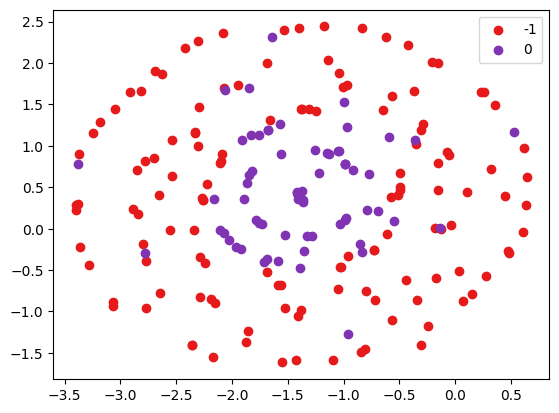

In [61]:
import numpy as np
from matplotlib import cm

kmeans = DBSCAN(eps=2, min_samples=2).fit(tfidf_data)
cdict = {i:cm.Set1(i) for i in np.unique(kmeans.labels_)}
cdict = {-1: (0.9, 0.1, 0.1, 1.0), 0: (0.5, 0.2, 0.7, 1.0)}
print(cdict)
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, n_iter=500)
tsne = tsne_model.fit_transform(tfidf_data)
tsne = pd.DataFrame(tsne)
tsne['k'] = kmeans.labels_

for cluster in np.unique(kmeans.labels_): # plot data by cluster
    plt.scatter(x=tsne.where(tsne['k']==cluster)[0],
                y=tsne.where(tsne['k']==cluster)[1],
                color=cdict[cluster],
                label=cluster)

plt.legend();

## Method 2

In [93]:
textual_data = textual_data.drop('medical_terms', axis=1)
# textual_data['medical_terms'] = textual_data.apply(lambda x: find_symptoms(x), axis=1)
textual_data['combined_text'] = textual_data.apply(lambda row: ' '.join(row), axis=1)

In [94]:
textual_data

,opensxtrig_fatigue,opensxtrig_lhead,opensxtrig_vert,opensxtrig_cog,opensxtrig_tin,opensxtrig_naus,opensxtrig_weak,opensxtrig_ins,opensxtrig_breath,opensxtrig_exint,...,opensxtrig_bb,opensxtrig_anx,opensxtrig_dep,opensxtrig_hal,opensxtrig_mood,sx_other_open,othertests,other_diag_open,tx_other_open,combined_text
0,Periods Post-exertional malaise,Periods,Periods Sensory stimulation Video calls Pho...,Periods,Music Sensory stimulation,Periods Fatigue Hunger,Periods Fatigue,Relapses,Sitting upright Being active (e.g. being at w...,,...,,,,,,Numb hands and feet,,,Omega 3 Folate,Periods Post-exertional malaise Periods Perio...
1,,,,,,,,,,,...,,,,,,,,,,...
2,,,,,,,,,,,...,,,,,,,I had a hearing test for the tinnitus. It was ...,Tinnitus,"Iron supplements, didnt help. Menthol topical...",Really bad at night. Also af...
3,,,,,,,,,,,...,,,,,,,,,,My period itself ...
4,"Being active, just taking a shower, going out ...",,,"When tired, trying to concentrate eg having a ...",,,,,,,...,,,,,,,"Ct thorax with contrast MRI lumbar cervical,...",Unexplained neurological symptoms in the after...,,"Being active, just taking a shower, going out ..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,Fatigue worse after exertion. PEM. But never g...,,,,,,,,Worse on exertion and also suddenly at random ...,,...,,The first two weeks of the reaction were like ...,This one is just a normal reaction to having y...,"Mild olfactory hallucinations when crashing, A...",Again hard to untie from standard response to ...,Loss of feeling in bladder Loss of sexual fee...,Think I've ticked the right box re. urine but ...,,,Fatigue worse after exertion. PEM. But never g...
226,,,,,,,,,,,...,,,,,,,Serum protein electrophoresis,Pericardial effusion Gastroenteritis,Beta blockers PPIs,"Period Period, fo..."
227,before hormonal periods,after walking or trying to do things,,gets worse after eating,gets better when other symptoms abate,,depends on covid reinfections,depends on food eaten,depends on covid reinfection,depends on covid reinfection,...,depends of what I've eaten and covid reinfection,depends of what I've eaten and covid reinfection,depends of what I've eaten and covid reinfection,,depends of what I've eaten and covid reinfection,ear and nose cartilage seems to be breaking down,24 hr sodium,,,before hormonal periods after walking or tryin...
228,,Accompanied by heart palpitations,,,,Accompanied by heart palpitations,,,Accompanied by heart palpitations,"Exercise on an incline (e.g., going up stairs,...",...,,,,,,,Stress echocardiogram,,Fermented cod liver oil,Accompanied by heart palpitations Accompan...


In [100]:
vectorizer = TfidfVectorizer(lowercase=False, tokenizer=find_symptoms_adj, stop_words=None, preprocessor=None) # used to apply tfidf
tfidf_matrix = vectorizer.fit_transform(textual_data['combined_text'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), columns=vectorizer.get_feature_names_out())

c:\Users\smitj\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


['periods', 'post exertional malaise', 'periods', 'periods', 'sensory stimulation', 'video', 'phone', 'periods', 'music', 'sensory stimulation', 'periods', 'fatigue', 'hunger', 'periods', 'fatigue', 'sitting', 'day', 'relapse', 'relapse', 'post exertional malaise', 'relapse', 'relapse', 'relapse', 'sensory stimulation', 'video', 'phone', 'fatigue', 'sensory stimulation', 'video', 'phone', 'fine motor activities', 'standing', '', 'sensory stimulation', 'relapse', 'sensory stimulation', 'fatigue', 'relapse', 'numb hands', 'foot', '', 'folate']
[]
['night', 'fatigue', 'foot', 'hearing test', 'tinnitus', 'c reactive protein', 'esr', 'month', 'vaccine', 'tinnitus', 'iron supplements', 'didn t help', 'menthol', 'topical cream']
['periods']
['being active', 'shower', 'house', 'fatigue', 'tired', 'concentrate', 'conversation', 'rash', 'shingle', 'active', 'active i', 'body', 'sun', 'active', 'fatigue', 'day', 'active', 'fatigue', 'day', 'sitting', 'vaccine', 'i m tired', 'conversation', 'i m r

This is what the data looks like when it has been processed this way. It would be basically be converted into its symptoms/bio-medical data. The below contains a lot of noise, and will need to be cleaned further.

In [101]:
tfidf_df

,,,insect,laser,once,passed,pem,silent,throat,102lbs,...,yoyo,zap,zap feeling i,zap like feeling,zap of energy,zeolite,zinc,zipping near my heart muscle,zolfran,zyrtec
0,0.066272,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.153751,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
225,0.030717,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
226,0.240466,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
227,0.010564,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
228,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
